## Zeph

This repository contains the artifact for the OSDI 2021 submission ["Zeph: Cryptographic Enforcement of End-to-End Data Privacy"](osdi21-paper210-zeph.pdf). 

The current implementation of Zeph is an academic proof-of-concept prototype. The prototype is designed to focus on evaluating the overheads of enforcing privacy transformations on encrypted data streams in Apache Kafka/Kafka Streams. The current prototype is not meant to be directly used for applications in productions. Note that currently - and as we mentioned in our submission - the orchestration of transformation, i.e., the policy manager's role is emulated with ansible scripts that run the end-to-end benchmark. 

This repository is structured as follows.
For more information, see the individual README files in the corresponding folders.

#### Zeph Components

- [**Zeph-client**](zeph-client/README.md): This folder contains Zeph's client library's implementation. It contains the data producer and privacy controller implementation.

- [**Zeph-server**](zeph-server/README.md): This folder contains Kafka's server library implementation. In its essence, the data transformer is a stream processor that performs privacy-preserving transformations on encrypted data streams by leveraging a stream of privacy transformation tokens.

#### Zeph Utility

- [**Zeph-crypto**](zeph-crypto/README.md): This folder holds the implementation of the cryptographic material for Zeph. It contains the native implementation of the secure aggregation protocol for the Strawman, Dream, and Zeph Optimization and the implementation of the stream encryption.

- [**Zeph-shared**](zeph-shared/README.md): This folder holds the implementations of the shared components of the client and the server of Zeph (e.g., Avro record, pojo, serde).

#### Zeph Benchmarks and Evaluation

- [**Zeph-benchmarks**](zeph-benchmarks/README.md): This folder holds all the material relevant to the microbenchmarks and the end-to-end evaluation of Zeph. Zeph Dashboard and a demo of Zeph as well can be found in this folder.

- [**Ansible**](ansible/README.md): The ansible playbooks we made to help and assist in navigating and automatically setting up and running the benchmarks on AWS for Zeph.

## Experiments

We provide a [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) environment to run the experiments and evaluate the artifact of Zeph.
Our JupyterLab environment contains further documentation, runnable code cells to run benchmarks locally or on AWS (using `!` to run shell commands), and runnable code cells to recreate the plots from the paper. 

To execute a selected cell, either click on the run button in the toolbar or use `Ctrl + Enter`.
To keep the JupyterLab readable, cells containing longer code sections to create plots are initially collapsed (indicated by three dots). However, by clicking on the dots, the cell containing the code expands (`View/Collapse Selected Code` to collapse the code again).

**Note that the shell commands to execute benchmarks are by default commented out. Uncomment to initiate the runs for these benchmarks.** (remove `#` before or `"""` enclosing the shell command)

#### AWS
AWS login information can be found in the Artifact submission system. This will allow the  Artifact reviewers to run the evaluation on the same resources stated in the paper submission. The experiments on AWS are automated with ansible-playbooks and can be called from the JupyterLab environment.

**Please ensure that the AWS resources are cleaned up if they are not used in the artifact**  
If the playbook terminates normally (i.e., without error and is not interrupted), then the playbook ensures that the created resources are also cleaned up.
When in doubt, please run the `ansible/awscleanup.yml` playbook with the command below or contact the authors to avoid unnecessary costs.

In [1]:
%%time
# Uncomment and run to terminate all resources on AWS (in case of an error, try to repeat and otherwise contact the authors) 

#!ansible-playbook ansible/awscleanup.yml -i ansible/inventory --private-key ~/.ssh/id_rsa_zeph

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


## Getting Started (Zeph JupyterLab)

### Initial Steps (~20 min)
1. Clone the code from GitHub [Zeph](https://github.com/pps-lab/zeph)

2. Reviewers should have received a private key: `id_rsa_zeph` and AWS credentials 
     1. move the provided private key `id_rsa_zeph` to the `aws-material` folder of the cloned project (reviewers should have received the key, otherwise contact us) 
     2. Copy/Paste the provided AWS credentials in `aws-material/boto`: 
    ```
    [Credentials]
    aws_access_key_id = {YOUR_AWS_ACCESS_KEY_ID}
    aws_secret_access_key = {YOUR_AWS_ACCESS_KEY}
    ```

3. Build the docker Image (~7 min)
```
docker build --rm -t jupyter/zeph .
```

4. `[Optional]` Create a docker volume to persist potential benchmark results.
```
docker volume create zeph-data
```

5. Start JupyterLab, which launches the guide for the artifact evaluation:
```
docker run -it --rm -p 8888:8888 -v zeph-data:/home/jovyan/results/review-results:Z jupyter/zeph start.sh jupyter lab
```
```
# Without a volume
docker run -it --rm -p 8888:8888 jupyter/zeph start.sh jupyter lab
```

6. Access JupyterLab via a web browser with the link outputted in the console  

7. In JupyterLab, open `artifact.ipynb`. The documentation in the notebook guides through the different parts of the artifact. **Continue from here in JupyterLab (same text as in the readme)**

8. Run all cells with `Run / Run All Cells` (~ 10 sec). Note that the (long-running) shell commands are initially commented out.  

9. Test the JupyterLab setup by running the two commands below to check whether things are configured properly.

#### Imports and Initialization

In [2]:
# ensure review results directories are present
!mkdir -p results/review-results/aws
!mkdir -p results/review-results/local

# imports and path handling of files
import os, json, math, glob
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from IPython.display import display, Markdown, HTML, clear_output

pd.set_option('display.max_colwidth', None)

def get_result_path(source, file_d={"paper": "", "aws": "", "local": ""}):
    if source == "paper":
        return os.path.join("results/paper", file_d["paper"])
    elif source == "aws":
        return os.path.join("results/review-results/aws", file_d["aws"])
    elif source == "local":
        return os.path.join("results/review-results/local", file_d["local"])
    else:
        raise ValueError("unknown source: must be one of [paper, aws, local]")


#### Running all Microbenchmarks locally with minimal configuration (~2 min)

In [3]:
%%time
# Running all Microbenchmarks locally with minimal configuration to check that the local setup works. (~2 min) 

"""
!java -jar zeph-benchmarks/zeph-microbenchmarks/target/zeph-microbenchmarks-1.0.jar \
    testEncode$ testEncodeEncrypt$ testECDH$ testErdosRenyiNative$ testDreamNative$ testStrawmanNative$ testUniverseDelta$ \
    -foe true -f 0 -wi 0 -i 1 -rf json -rff results/review-results/local/minimal.json -p dataDir=data \
    -p encoderConfig=avg \
    -p size_win=100_256 \
    -p universeSize=1000 -p addE_addNE_dropE_dropNE=0_10_0_10 \
    2>&1 | tee logs/mbench_minimal.log
"""
clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_minimal.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_minimal.log))

CPU times: user 5.35 ms, sys: 646 µs, total: 5.99 ms
Wall time: 5.1 ms


#### Check Configuration to run Zeph on AWS (~3 min)

Before executing the command we recommend to login to the [AWS Management Console](https://226594459110.signin.aws.amazon.com/console) with the provided credentials.
In the management console select the London region (eu-west-2) and open the EC2 service. This allows to observe what the minimal ansible playbook does.

The minimal playbook will:
1. create a VPC
2. start one EC2 instance
3. clone Zeph from GitHub
4. reset the AWS environment (terminate instance, remove VPC)

In case something fails, ensure that the provided aws material (private key and credentials) are placed as described above.  

In [4]:
%%time
#!ansible-playbook ansible/minimal.yml -i ansible/inventory --private-key ~/.ssh/id_rsa_zeph --ssh-common-args='-o StrictHostKeyChecking=no' 2>&1 | tee logs/aws_minimal.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/aws_minimal.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/aws_minimal.log))

CPU times: user 841 µs, sys: 2.51 ms, total: 3.35 ms
Wall time: 2.77 ms


## Running Experiments
We assume that the following steps are followed within the JupyterLab environment. 
For each result shown in the paper, we have a separate section.
Each section contains:

1. Code to produce the results in form of a table based on the output files from the benchmarks

2. Code to create the plot shown in the paper from the results table

3. Code that displays both the results and the figure and allows you to switch between the results from the paper and the reproduced results

4. The command to reproduce the results (locally / on aws for microbenchmarks, and on aws for the end-to-end benchmark. You can uncomment the command and run the cell with `Ctrl + Enter`.

Note that for improved readability, the code for creating the table and the plot is initially collapsed but can be openend by clicking on the three dots. To collapse the code again, select the cell by clicking on it and then go to `View/Collapse Selected Code`.

JupyterLab code cells are blocking which means that when executing a cell (e.g., run a benchmark), we cannot run another cell until the previous cell finished.
As a result, it might be to better for long running commands to copy the shell command (excluding the comment and  `!`) and execute it in a Jupyter terminal.

In any case, while running a benchmark in a cell or a terminal, keep the JupyterLab session open and ensure that the internet connection is stable (for AWS).

In [5]:
HTML(' <a href="", data-commandlinker-command="terminal:create-new" >Open new Terminal</a>')

### Microbenchmarks (Figure 5,6,7,8 and Table 1)


#### Running all Microbenchmarks on AWS EC2 (3h 20min)
All microbenchmarks in the paper run on a single AWS EC2 instance.
Since running all microbenchmarks takes quite a bit of time, we provide two ansible playbook commands to help with the process.

1. The ansible playbook with the tag "start" initializes the AWS environment (e.g., creates a VPC, creates a single EC2 instance), fetches the current version of the code from GitHub, and builds Zeph. Afterwards it starts a systemd service `microbenchmark.service` on the remote machine to run all the microbenchmarks.

2. The ansible playbook with the tag "result" checks repeatedly (up to 100 times with a 15s delay in between) whether the `microbenchmark.service` is still running. As soon as the service stopped, the playbook fetches the benchmark result file into the local folder (`results/review-results/aws`). From there we can reproduce the figures from the paper as described below.


In [6]:
HTML(' <a href="", data-commandlinker-command="terminal:create-new" >Open new Terminal</a> (alternative to execute shell command in a blocking cell)')

In [7]:
%%time
# Command to start all microbenchmarks (~ 14 min)

# Note `-o StrictHostKeyChecking=no` allows to directly connect to the newly created ec2 machine

#!ansible-playbook ansible/mbenchpaper.yml -i ansible/inventory -e "run_id=0" --private-key ~/.ssh/id_rsa_zeph --ssh-common-args='-o StrictHostKeyChecking=no' --tags "start" 2>&1 | tee logs/mbench_aws_start.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_aws_start.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_aws_start.log))

CPU times: user 3.4 ms, sys: 1.56 ms, total: 4.96 ms
Wall time: 5.26 ms


Running all microbenchmarks on EC2 takes ~ 3h 20min. 
The playbook below checks whether the microbenchmarks are finished and fetches the result file.

Note to observe the progress manually, use ssh to connect to the ec2 instance and look at the files in: `~/logs`. 
(`ssh ubuntu@<Public IPv4 DNS> -i ~/.ssh/id_rsa_zeph`)

In [8]:
%%time
# Command that waits for the microbenchmarks to finish and then fetches the result file. 
# (It waits for a maximum of 25 minutes before it aborts but you can also abort manually if the results are not ready yet and retry later)

# between ~ 2 min and 25 min depending on whether benchmark is complete. 

#!ansible-playbook ansible/mbenchpaper.yml -i ansible/inventory --private-key ~/.ssh/id_rsa_zeph --tags "result" 2>&1 | tee logs/mbench_aws_result.log


clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_aws_result.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/mbench_aws_result.log))

CPU times: user 1.14 ms, sys: 2.68 ms, total: 3.82 ms
Wall time: 3.06 ms


#### `Optional:` Running Microbenchmarks Locally

Before running microbenchmarks locally, you have to build Zeph (in the Standard Application) with the command `mvn clean install` as shown below.
Note, that Zeph in the standard application is already built when building the Docker container. So only rebuild Zeph if you switch the application or something fails. 
For each of the figures, we provide the command to run the corresponding microbenchmark.

In [9]:
%%time

# Build Zeph (in the Standard Application)  (~6 min)
#!mvn clean install 2>&1 | tee logs/build_zeph_standard.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_standard.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_standard.log))

CPU times: user 4 ms, sys: 12 µs, total: 4.01 ms
Wall time: 3.49 ms


### Data Producer (Figure 5)

Code Marker: [EncoderBenchmark.java](zeph-benchmarks/zeph-microbenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/EncoderBenchmark.java)

#### `Optional:` Run the Microbenchmark for Figure 5 locally (~40min)

In [10]:
%%time
#!java -jar zeph-benchmarks/zeph-microbenchmarks/target/zeph-microbenchmarks-1.0.jar testEncode testEncodeEncrypt -rf json -rff results/review-results/local/figure5_out.json -p encoderConfig=count,sum,avg,var,hist_10,reg 2>&1 | tee logs/figure5.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/figure5.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/figure5.log))

CPU times: user 4.79 ms, sys: 368 µs, total: 5.16 ms
Wall time: 5.21 ms


#### Description

The overhead of the data producer consists of encoding and encrypting records in Zeph's symmetric additive homomorphic encryption scheme. We measure the computational overhead with a microbenchmark and we show analytically how the bandwidth requirements depends on the applied encoding.

For the benchmark run on the Raspberry Pi, we only provide the results from the paper. (However, you could build Zeph on the Raspberry Pi and run the benchmark with the comand below)

In [11]:
def build_figure5_df(file):
    try:
        with open(file) as json_file:
            data = json.load(json_file)
    except (FileNotFoundError, ValueError) as e:
        return None
    
    res_encode = []
    res_encode_encrypt = []

    for exp in data:
        benchmark = exp['benchmark'].split(".")[-1]
        
        if benchmark not in ["testEncode", "testEncodeEncrypt"]:
            continue
    
        exp["primaryMetric"]["rawData"]
    
        if "Raspbian" in exp["vmVersion"]:
            system = "raspbian"
        elif "Ubuntu" in exp["vmVersion"]:
            system = "ubuntu"
        else:
            raise ValueError(f"unknown vm version {exp['vmVersion']}")



        rt_us = 1/(exp["primaryMetric"]["score"]/1000000)
        rts_us = [1/(x/1000000) for x in exp["primaryMetric"]["rawData"][0]]
        rt_stddev_us = stat.stdev(rts_us)

        tp_stddev = stat.stdev(exp["primaryMetric"]["rawData"][0])

        if benchmark == "testEncode":

            parts = exp["params"]["encoderConfig"].split("_")
            config = parts[1] if len(parts)> 1 else "-"

            d = {
                "system": system,
                "encoding": parts[0],
                "config": config,
                "tp_encode": int(exp["primaryMetric"]["score"]),
                "tp_encode_stdev": tp_stddev,
                "rt_encode_us": rt_us,
                "rt_encode_stdev_us": rt_stddev_us
            }
            res_encode.append(d)

        elif benchmark == "testEncodeEncrypt":
            parts = exp["params"]["encoderConfig"].split("_")
            config = parts[1] if len(parts)> 1 else "-"
            d = {
                "system": system,
                "encoding": parts[0],
                "config": config,
                "tp_encode_encrypt": int(exp["primaryMetric"]["score"]),
                "tp_encode_encrypt_stdev": tp_stddev,
                "rt_encode_encrypt_us": rt_us,
                "rt_encode_encrypt_stdev_us": rt_stddev_us
            }
            res_encode_encrypt.append(d)


    df_encode = pd.DataFrame(res_encode)
    df_encode_encrypt = pd.DataFrame(res_encode_encrypt)

    df = df_encode.merge(df_encode_encrypt, how='outer', on=['system', 'encoding', 'config'])
    
    
    df["rt_encrypt_us"] = df["rt_encode_encrypt_us"] - df["rt_encode_us"]
    df["encode_percent"] = df["rt_encode_us"] / df["rt_encode_encrypt_us"]
    df["encrypt_percent"] = 1 - df["encode_percent"] 

    df = df.round({'encode_percent': 2, 'encrypt_percent': 2})

    df = df.sort_values(["system","rt_encode_encrypt_us"])    
    
    # select the presented encodings
    encodings =  ["count", "sum", "avg", "var", "reg", "hist"]
    df = df[df["encoding"].isin(encodings) & ((df["config"]=="-")|(df["config"]=="10"))]
    
    # project 
    df = df[["system", "encoding", "rt_encode_us", "rt_encrypt_us", "rt_encode_encrypt_stdev_us", "tp_encode_encrypt"]]
    return df

def build_figure_5a(data, format_plot):
    print("Figure 5a: EC2 Instance")
    df1 = data[data["system"]=="ubuntu"]
    df1 = df1[df1.encoding.isin(["sum", "avg", "var", "reg", "hist"])]
    _build_stacked_barchart(values1=df1["rt_encode_us"], label1="Encode",
                            values2=df1["rt_encrypt_us"], label2="Encrypt",
                            err=df1["rt_encode_encrypt_stdev_us"],
                            labels=df1["encoding"], y_label="Computation [μs]", ytick_base=0.4, format_plot=format_plot)
    

def build_figure_5b(data):
    print("Figure 5b: EC2 Raspberry Pi")
    
    df1 = data[data["system"]=="raspbian"] 
    df1 = df1[df1.encoding.isin(["sum", "avg", "var", "reg", "hist"])]

    _build_stacked_barchart(values1=df1["rt_encode_us"], label1="Encode",
                            values2=df1["rt_encrypt_us"], label2="Encrypt",
                            err=df1["rt_encode_encrypt_stdev_us"],
                            labels=df1["encoding"], y_label="Computation [μs]", ytick_base=20)
    
def build_producer_bandwidth_df(timestamp_bytes=8, value_bytes=8, num_buckets=10):
    # both the timestamp and a value is represented by a long (8 bytes)
    # for encodings based on buckets (hist, max, min), we use as stated by default 10 buckets

    encodings = [("sum", 1), ("count", 1), ("avg", 2), ("var", 3), ("hist", num_buckets), ("max", num_buckets), ("min", num_buckets), ("reg", 5)]
    results = []

    plaintext_bytes  = value_bytes + timestamp_bytes

    for name, fields in encodings:
        d = {
            "encoding": name,
            "fields": fields,
            "size_bytes": fields * value_bytes + 2 * timestamp_bytes,
        }
        results.append(d)

    df = pd.DataFrame(results)
    df["expansion_factor"] = df["size_bytes"] / plaintext_bytes
    
    df = df[df.encoding.isin(["sum", "avg", "var", "reg", "hist"])]
    df = df.transpose()
    return df


    
    
def _build_stacked_barchart(values1, label1, values2, label2, labels, err, y_label, ytick_base=1, x_label=None, format_plot=True):
    
    
    plt_params = {'backend': 'ps',
              'axes.labelsize': 20,
              'legend.fontsize': 16,
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'font.size': 18,
              'figure.figsize': [4.151100041511, 2.736555644111891],
              'font.family': 'times new roman'}
    
    plt.rc('pdf', fonttype=42) 
    plt.rcParams.update(plt_params)
    
    colors=['0.3', '0.6']
    
    
    f, ax1 = plt.subplots()

    
    ind = np.arange(0, len(labels)) * 1.2
    width = 0.8
    
    bars1 = ax1.bar(ind, values1, width, label=label1, zorder=3)
    bars2 = ax1.bar(ind, values2, width, yerr=err ,bottom=values1, label=label2, zorder=3, capsize=3)

    for id, bar in enumerate(bars1):
        bar.set_facecolor(colors[0])
    
    for id, bar in enumerate(bars2):
        bar.set_facecolor(colors[1])
    
            
    ax1.legend()
    
    # format x axis
    ax1.set_xlabel(x_label)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(labels, rotation=345)
    
    # format y axis
    ax1.set_ylabel(y_label)
    ax1.set_ylim(ymin=0)

    
    ax1.yaxis.grid(True, linestyle=':', color='0.6', zorder=0, linewidth=1.2)
    
    if ytick_base is not None and format_plot:
        loc = plticker.MultipleLocator(base=ytick_base)
        ax1.yaxis.set_major_locator(loc)
    
    plt.show()
    print("\n")



#### Paper Results

Figure 5a: EC2 Instance


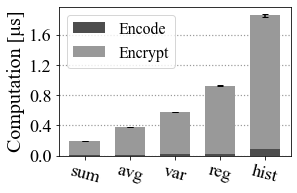



Figure 5b: EC2 Raspberry Pi


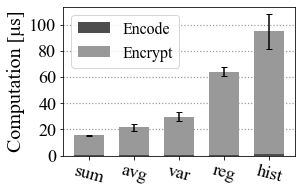

,system,encoding,rt_encode_us,rt_encrypt_us,rt_encode_encrypt_stdev_us,tp_encode_encrypt
12,raspbian,count,0.142254,12.913445,1.186721,76594
11,raspbian,sum,0.196692,15.404380,0.464332,64098
13,raspbian,avg,0.252038,21.346736,2.917521,46298
14,raspbian,var,0.393480,29.369783,3.549119,33598
21,raspbian,reg,0.569529,63.558873,3.478552,15593
16,raspbian,hist,1.083401,93.985279,13.259081,10518
1,ubuntu,count,0.006086,0.181359,0.000120,5334897
0,ubuntu,sum,0.009204,0.181986,0.000872,5230389
2,ubuntu,avg,0.013471,0.369522,0.000307,2611013
3,ubuntu,var,0.017864,0.557062,0.000272,1739354


---

#### AWS Results

does not exist yet


---

#### Local Results

does not exist yet


---

#### Bandwidth

,0,2,3,4,7
encoding,sum,avg,var,hist,reg
fields,1,2,3,10,5
size_bytes,24,32,40,96,56
expansion_factor,1.5,2.0,2.5,6.0,3.5


In [12]:
file_d = {"paper": "figure5_out.json", "aws": "jmh-microbenchmark-results_0.json", "local": "figure5_out.json"}

def output(source):
    
    df = build_figure5_df(file=get_result_path(source.lower(), file_d))
    
    display(Markdown(f"#### {source} Results"))
    
    if df is None:
        print("does not exist yet")
    else:
        build_figure_5a(data=df, format_plot=source!="Local")
        if source == "Paper": # raspberry pi only for paper
            build_figure_5b(data=df)
        display(df)
    
    display(Markdown("---"))

for source in ["Paper","AWS","Local"]:
    output(source)

display(Markdown(f"#### Bandwidth"))
df_bandwidth = build_producer_bandwidth_df()
display(df_bandwidth)

### Privacy Controller - Setup Phase (Table 1)

Code Marker: [ECDHBenchmark.java](zeph-benchmarks/zeph-microbenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/crypto/ECDHBenchmark.java)

#### `Optional:` Run the Microbenchmark for Table 1 locally (~10 min)

In [13]:
%%time
# Run the Microbenchmark for Table 1 locally (~10 min)

#!java -jar zeph-benchmarks/zeph-microbenchmarks/target/zeph-microbenchmarks-1.0.jar testECDH -rf json -rff results/review-results/local/table1_out.json 2>&1 | tee logs/table1.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/table1.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/table1.log))

CPU times: user 4.58 ms, sys: 182 µs, total: 4.76 ms
Wall time: 4.24 ms


#### Description 
In the setup phase of the secure aggregation protocol, all involved privacy controllers participate in a Diffie-Hellman Key Exchange (ECDH).  
We benchmark the computational cost for a single key exchange and extrapolate the cost for all key exchanges. 
The bandwidth and storage requirements are estimated based on the size of the keys that need to be distributed and stored. 

In [14]:
def build_table1_df(file, config):
    
    n_privacy_controllers = [100, 1000, 10000, 100000]
    
    df_ecdh = load_ecdh(n_privacy_controllers=n_privacy_controllers, result_file=file)
    
    if df_ecdh is None:
        return None
    df_size = load_size_estimates(n_privacy_controllers=n_privacy_controllers, config=config)

    df = df_ecdh.merge(df_size, how='outer', on=['n_privacy_controller'])
    df['others'] = df['n_privacy_controller']-1
    
    
    df = df[['n_privacy_controller', 'ecdh_public_key_bytes', 'ecdh_public_key_mb_global', 'shared_keys_bytes', 'ecdh_latency_ms', 'ecdh_latency_global_ms']]
    
    df = df.rename(columns={"ecdh_public_key_bytes": "Bandwidth [bytes]", "ecdh_public_key_mb_global": "Bandwidth Total [MB]", "shared_keys_bytes": "Shared Keys [bytes]", 'ecdh_latency_ms': "ECDH [ms]", 'ecdh_latency_global_ms': "ECDH Total [ms]"})

    return df


def load_ecdh(n_privacy_controllers, result_file):
    try:
        with open(result_file) as json_file:
            data = json.load(json_file)
    except (FileNotFoundError, ValueError) as e:
        return None
    
    results = []
    
    for exp in data:
        benchmark = exp['benchmark'].split(".")[-1]
        if benchmark == "testECDH" and exp['mode']=="avgt":
            ms_per_op = exp["primaryMetric"]["score"] * 1000  
            for n_pc in n_privacy_controllers:
                d = {
                    "n_privacy_controller": n_pc,
                    "ecdh_latency_ms": (n_pc-1) * ms_per_op,
                    "ecdh_latency_global_ms": n_pc*(n_pc-1) * ms_per_op
                }
                results.append(d)
    df = pd.DataFrame(results)
    return df


def load_size_estimates(n_privacy_controllers, config):
    
    results = []
    for n_pc in n_privacy_controllers:
        d = {
            "n_privacy_controller": n_pc,
            "certs_bytes": config["x509_ecdh_certificate_bytes"] * (n_pc-1),
            "ecdh_public_key_bytes": config["ecdh_public_key_bytes"] * (n_pc-1),
            "shared_keys_bytes": config["shared_key_bytes"] * (n_pc-1),
            "private_key_bytes": config["ecdh_private_key_bytes"],
            #"token_per_window_bytes": config["number_of_fields"] * config["field_bytes"] * n_pc,
            #"values_per_window_mb": config["number_of_fields"] * config["field_bytes"] * n_pc * config["number_of_values_per_window"] * 10**(-6)
        }
        results.append(d)

    df = pd.DataFrame(results)

    df['shared_keys_mb'] =  df['shared_keys_bytes'] * 10**(-6)
    df['certs_mb'] =  df['certs_bytes'] * 10**(-6)

    df['certs_mb_global'] =  df['certs_bytes'] * 10**(-6) * df['n_privacy_controller']
    df['certs_gb_global'] =  df['certs_bytes'] * 10**(-9) * df['n_privacy_controller']

    df['ecdh_public_key_mb_global'] =  df['ecdh_public_key_bytes'] * 10**(-6) * df['n_privacy_controller']
    
    return df



In [15]:
file_d = {"paper": "table1_out.json", "aws": "jmh-microbenchmark-results_0.json", "local": "table1_out.json"}

# numbers for ecdh_curve secp256r1 in Java
config = {
    "ecdh_private_key_bytes": 150,
    "ecdh_public_key_bytes": 91,
    "x509_ecdh_certificate_bytes": 366,
    "shared_key_bytes": 32,
}


def output(source):
    
    df = build_table1_df(file=get_result_path(source.lower(), file_d), config=config)
    
    display(Markdown(f"#### {source} Results"))
    
    if df is None:
        print("does not exist yet")
    else:
        display(df)
    
    display(Markdown("---"))

for source in ["Paper","AWS","Local"]:
    output(source)


#### Paper Results

,n_privacy_controller,Bandwidth [bytes],Bandwidth Total [MB],Shared Keys [bytes],ECDH [ms],ECDH Total [ms]
0,100,9009,0.9009,3168,24.691225,2.469123e+03
1,1000,90909,90.9090,31968,249.156907,2.491569e+05
2,10000,909909,9099.0900,319968,2493.813727,2.493814e+07
3,100000,9099909,909990.9000,3199968,24940.381926,2.494038e+09


---

#### AWS Results

does not exist yet


---

#### Local Results

does not exist yet


---

### Privacy Controller - Transformation Phase: Secure Aggregation Optimization  (Figure 6)

Code Marker: [TransformationTokenNativeBenchmark.java](zeph-benchmarks/zeph-microbenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/crypto/TransformationTokenNativeBenchmark.java)

#### `Optional:` Run the Microbenchmark for Figure 6 locally (~3h)

In [16]:
HTML(' <a href="", data-commandlinker-command="terminal:create-new" >Open new Terminal</a> (alternative to execute shell command in a blocking cell)')

In [17]:
%%time
#!java -jar zeph-benchmarks/zeph-microbenchmarks/target/zeph-microbenchmarks-1.0.jar testErdosRenyiNative testDreamNative testStrawmanNative -rf json -rff results/review-results/local/figure6_out.json -p dataDir=data -p size_win=100_256,1000_512,2000_800,5000_1344,10000_2304,1000_1,1000_8,1000_16,1000_64,1000_128 2>&1 | tee logs/figure6.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/figure6.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/figure6.log))

CPU times: user 6.23 ms, sys: 0 ns, total: 6.23 ms
Wall time: 5.56 ms


#### Description

In the transformation phase, a privacy controller creates a token to authorize a transformation. 
For multi-stream aggregations, this involves a secure aggregation protocol to hide the decrpytion key with a mask.

We benchmark the computational cost involved in creating such a token with the Strawman Secure Aggregation protocol, the Dream optimization, and the new Zeph optimization (in the code called `erdos_renyi (er)`.

In [18]:
def build_figure6_df(file):
    
    try:
        with open(file) as json_file:
            data = json.load(json_file)
    except (FileNotFoundError, ValueError) as e:
        return None
    
    erdos_renyi = []
    dream = []
    strawman = []

    optimal_w = {
        "100": "256",
        "200": "256",
        "500": "336",
        "1000": "512",
        "2000": "800",
        "5000": "1344",
        "10000": "2304"
    }

    for x in data:
        benchmark = x['benchmark'].split(".")[-1]

        if benchmark not in ['testErdosRenyiNative', 'testStrawmanNative', 'testDreamNative']:
            continue

        size_win = x['params']['size_win'].split("_")
        parties = size_win[0]
        rounds = size_win[1]
        tp = x['secondaryMetrics']['count']['score']

        avg_time_ms = 1 / (tp/1000)

        rt_ms = 1/(x['secondaryMetrics']['count']["score"]/1000)
        rts_ms = [1/(x1/1000) for x1 in x['secondaryMetrics']['count']["rawData"][0]]
        rt_stddev_ms = stat.stdev(rts_ms)

        tp_stddev = stat.stdev(x['secondaryMetrics']['count']["rawData"][0])

        d = {"parties": int(parties), 
             "rounds": int(rounds), 
             "tp_rps": float(tp), 
             "avg_time_ms": avg_time_ms,
             "tp_stddev": tp_stddev,
             "avg_time_stddev":rt_stddev_ms
            }

        if benchmark == 'testErdosRenyiNative':
            d["opt_er"] = optimal_w[parties] == rounds
            erdos_renyi.append(d)
        elif benchmark == 'testStrawmanNative':
            strawman.append(d) 
        elif benchmark == 'testDreamNative':
            dream.append(d)
    
    
    df_dream = pd.DataFrame(dream).rename(columns={"tp_rps": "tp_dream", "avg_time_ms": "avg_time_dream_ms", "tp_stddev": "tp_stddev_dream", "avg_time_stddev": "avg_time_stddev_dream"})
    df_strawman = pd.DataFrame(strawman).rename(columns={"tp_rps": "tp_strawman", "avg_time_ms": "avg_time_strawman_ms", "tp_stddev": "tp_stddev_strawman", "avg_time_stddev": "avg_time_stddev_strawman"})
    df_erdos_renyi = pd.DataFrame(erdos_renyi).rename(columns={"tp_rps": "tp_er", "avg_time_ms": "avg_time_er_ms" ,"tp_stddev": "tp_stddev_er", "avg_time_stddev": "avg_time_stddev_er"})

    df_prev = df_dream.merge(df_strawman, how='outer', on=['parties', 'rounds'])


    df = df_prev.merge(df_erdos_renyi, how='outer', on=['parties', 'rounds'])
    df.sort_values(by=['parties', 'rounds'], inplace=True)
    
    df = df[["parties", "rounds", "opt_er", 
             "avg_time_er_ms", "avg_time_stddev_er", 
            "avg_time_dream_ms", "avg_time_stddev_dream",
            "avg_time_strawman_ms", "avg_time_stddev_strawman"]]
    
    df["er_vs_strawman"] = (df["avg_time_strawman_ms"]/df["avg_time_er_ms"]).apply(lambda x: f"{int(round(x))}x")
    df["er_vs_dream"] = (df["avg_time_dream_ms"]/df["avg_time_er_ms"]).apply(lambda x: f"{int(round(x))}x")
    
    return df
    
def build_figure_6a(data, format_plot):
    
    labels = []
    for l in data["parties"]:
        if l >= 1000:
            labels.append(str(int(l/1000)) + "k")
        else:
            labels.append(l)
    
    _barchart(labels=labels, x_label="Parties", 
                values1=data['avg_time_er_ms'], label1="Zeph", err1=data['avg_time_stddev_er'],
                values2=data['avg_time_dream_ms'], label2="Dream", err2=data['avg_time_stddev_dream'],
                values3=data['avg_time_strawman_ms'], label3="Strawman", err3=data['avg_time_stddev_strawman'],
                ytick_base=0.5, format_plot=format_plot)
    

def build_figure_6b(data, format_plot):
    labels = []
    for l in data["rounds"]:
        if l >= 1000:
            labels.append(str(int(l/1000)) + "k")
        else:
            labels.append(l)
    
    _barchart(labels=labels, x_label="Rounds", 
                values1=data['avg_time_er_ms'], label1="Zeph", err1=data['avg_time_stddev_er'],
                values2=data['avg_time_dream_ms'], label2="Dream", err2=data['avg_time_stddev_dream'],
                values3=data['avg_time_strawman_ms'], label3="Strawman", err3=data['avg_time_stddev_strawman'],
                ytick_base=0.05, format_plot=format_plot)
    
    
def _barchart(labels, x_label, 
                values1, label1, err1,
                values2, label2, err2,
                values3, label3, err3,
                ytick_base=None,format_plot=True):

    colors=['0.1', '0.45', '0.7']
    
    plt_params = {'backend': 'ps',
              'axes.labelsize': 20,
              'legend.fontsize': 16,
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'font.size': 18,
              'figure.figsize': [4.151100041511, 2.736555644111891],
              'font.family': 'times new roman'}
    
    plt.rc('pdf', fonttype=42) 
    plt.rcParams.update(plt_params)
    
    f, ax1 = plt.subplots()
    
    ind = np.arange(0, len(labels)) * 1.2
    bars1 = bars2 = bars3 = None
    
    capsize = 3
    
    width = 0.3  # the width of the bars
    offset = width
    bars1 = ax1.bar(ind - width, values1, width, label=label1, zorder=3, yerr=err1, capsize=capsize)
    bars2 = ax1.bar(ind,         values2, width, label=label2, zorder=3, yerr=err2, capsize=capsize)
    bars3 = ax1.bar(ind + width, values3, width, label=label3, zorder=3, yerr=err3, capsize=capsize)
    min_value = min(values1 + values2 + values3)
    max_value = max(values1 + values2 + values3) 
    

    for id, bar in enumerate(bars1):
        bar.set_facecolor(colors[0])
    
    if bars2:
        for id, bar in enumerate(bars2):
            bar.set_facecolor(colors[1])
    
    if bars3:
        for id, bar in enumerate(bars3):
            bar.set_facecolor(colors[2])
    
            
    # format x axis
    ax1.set_xlabel(x_label)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(labels, rotation=345)
    
    legend = plt.legend(bbox_to_anchor=(0, 1.02,1, 0.2), loc="lower left", mode="expand")
    
    # format y axis
    ax1.set_ylabel("Computation [ms]")
    if min_value > 400000 and max_value > 2000000:
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '%.1fM' % (y * 1e-6)))
    
    plt.gca().yaxis.grid(True, linestyle=':', color='0.6', zorder=0, linewidth=1.2)
    
    ax1.set_ylim(ymin=0, ymax=None)
    
    if format_plot:
        loc = plticker.MultipleLocator(base=ytick_base)
        ax1.yaxis.set_major_locator(loc)
    
    plt.show()

#### Paper Results

Figure 6a: Average per Round


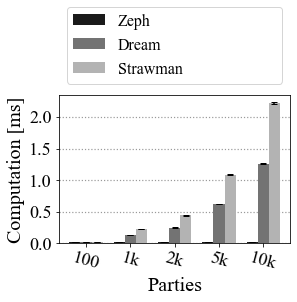

,parties,rounds,opt_er,avg_time_er_ms,avg_time_stddev_er,avg_time_dream_ms,avg_time_stddev_dream,avg_time_strawman_ms,avg_time_stddev_strawman,er_vs_strawman,er_vs_dream
25,100,256,True,0.014882,0.000049,0.020858,0.000067,0.024648,0.000081,2x,1x
10,1000,512,True,0.018208,0.000099,0.133560,0.000591,0.221207,0.000084,12x,7x
28,2000,800,True,0.018379,0.000074,0.250294,0.001180,0.441289,0.001595,24x,14x
29,5000,1344,True,0.022417,0.000098,0.622989,0.002355,1.089592,0.003651,49x,28x
23,10000,2304,True,0.023130,0.000028,1.263283,0.013793,2.227773,0.016268,96x,55x





Figure 6b: Varied Rounds for 1k Parties


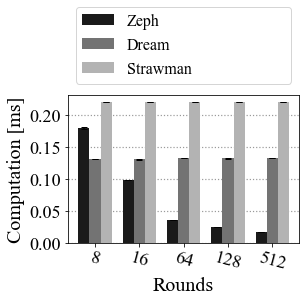

,parties,rounds,opt_er,avg_time_er_ms,avg_time_stddev_er,avg_time_dream_ms,avg_time_stddev_dream,avg_time_strawman_ms,avg_time_stddev_strawman,er_vs_strawman,er_vs_dream
4,1000,8,False,0.180647,0.001689,0.132006,0.000519,0.221286,0.000152,1x,1x
5,1000,16,False,0.099266,0.000382,0.131152,0.000601,0.220955,0.000066,2x,1x
7,1000,64,False,0.036403,0.000168,0.133543,0.000558,0.221561,0.000065,6x,4x
8,1000,128,False,0.025973,0.000005,0.133021,0.000474,0.221238,0.000126,9x,5x
10,1000,512,True,0.018208,0.000099,0.133560,0.000591,0.221207,0.000084,12x,7x



 First Round:


,parties,rounds,opt_er,avg_time_er_ms,avg_time_stddev_er,avg_time_dream_ms,avg_time_stddev_dream,avg_time_strawman_ms,avg_time_stddev_strawman,er_vs_strawman,er_vs_dream
3,1000,1,False,1.333075,0.00746,0.130519,0.000487,0.220113,0.000078,0x,0x


---

#### AWS Results

does not exist yet


---

#### Local Results

does not exist yet


---

In [19]:
file_d = {"paper": "figure6_out.json", "aws": "jmh-microbenchmark-results_0.json", "local": "figure6_out.json"}

def output(source):
    
    df = build_figure6_df(file=get_result_path(source.lower(), file_d))
    
    display(Markdown(f"#### {source} Results"))

    if df is None:
        print("does not exist yet")
    else:
        print("Figure 6a: Average per Round")
        parties = [100, 1000, 2000, 5000, 10000]
        df_6a = df[df["parties"].isin(parties) & (df["opt_er"]==1)]
        build_figure_6a(data=df_6a, format_plot=source!="Local")

        display(df_6a)

        print("\n\n\nFigure 6b: Varied Rounds for 1k Parties")
        rounds =  [8, 16, 64, 128, 512]
        df_6b = df[df["rounds"].isin(rounds) & (df["parties"]==1000)]
        build_figure_6b(data=df_6b, format_plot=source!="Local")

        display(df_6b)
        
        print("\n First Round:")
        df_1st = df[(df["rounds"]==1) & (df["parties"]==1000)]
        display(df_1st)
        
    display(Markdown("---"))

for source in ["Paper","AWS","Local"]:
    output(source)

### Privacy Controller - Transformation Phase: Bandwidth (Figure 7a)
The bandwidth analysis of the privacy controller during the transformation phase includes coordination information about the transformation (e.g., which participant dropped out) and the transformation token itself. If more participants drop out, this means that the messages that include this information grow.

In [20]:
def build_figure7a_df(config):
    
    results = []
    for diff_percentage in config["diff_percentages"]:
        
        for num_controllers in config["controller_options"]:

            bandwidth_per_controller = _get_conroller_mpc_bandwidth_bytes(universe_size=num_controllers, diff_percentage=diff_percentage, encoding_size=3)

            d = {
                "num_controllers": num_controllers,
                "diff_percentage": diff_percentage,
                "diffs":  int(num_controllers * diff_percentage),
                "bandwidth_per_controller_KB": bandwidth_per_controller / 1000,
                "bandwidth_KB" : num_controllers * bandwidth_per_controller / 1000
            }

            results.append(d)

    df = pd.DataFrame(results)
    
    return df



    
def build_figure_7a(data):
    
    diff_percentages = data["diff_percentage"].unique()
    
    # we show three lines
    
    df0 = data[data["diff_percentage"] == diff_percentages[0]]
    df1 = data[data["diff_percentage"] == diff_percentages[1]]
    df2 = data[data["diff_percentage"] == diff_percentages[2]]
    
    labels = df0["num_controllers"]   
    
    colors = ["0.6", "0.3", "0.1"]
    linestyles = ['-', '--',':']
    
    plt_params = {'backend': 'ps',
              'axes.labelsize': 20,
              'legend.fontsize': 16,
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'font.size': 18,
              'figure.figsize': [4.151100041511, 2.736555644111891],
              'font.family': 'times new roman'}
    
    plt.rc('pdf', fonttype=42) 
    plt.rcParams.update(plt_params)
    
    f, ax1 = plt.subplots()    
    
    capsize = 5
    
    
    plt.errorbar(labels, df0["bandwidth_per_controller_KB"],  yerr=None, label=f"pΔ = {diff_percentages[0]}", color=colors[0], marker=None, linestyle=linestyles[0], linewidth=2, capsize=capsize)

    plt.errorbar(labels, df1["bandwidth_per_controller_KB"],  yerr=None, label=f"pΔ = {diff_percentages[1]}", color=colors[1], marker=None, linestyle=linestyles[1], linewidth=2, capsize=capsize)
    
    plt.errorbar(labels, df2["bandwidth_per_controller_KB"],  yerr=None, label=f"pΔ = {diff_percentages[2]}", color=colors[2], marker=None, linestyle=linestyles[2], linewidth=2, capsize=capsize)
    
    
    plt.gca().grid(True, linestyle=':', axis="y", color='0.6', zorder=0, linewidth=1)
    
    plt.xlabel("Number of Data Streams")
    plt.ylabel("Traffic [KB]")
  
    plt.ylim(ymin=0, ymax=10)


    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax1.legend(handles, labels ,numpoints=1, title=None ,labelspacing=.08)

    
    loc = plticker.MultipleLocator(base=2)
    ax1.yaxis.set_major_locator(loc)        

    loc = plticker.MultipleLocator(base=2000)
    ax1.xaxis.set_major_locator(loc)
    
    ax1.xaxis.set_major_formatter(lambda x, pos: f"{int(x/1000)}k")
      
    plt.show()



def _get_conroller_mpc_bandwidth_bytes(universe_size, diff_percentage=0.0, encoding_size=3):
    timestamp_size = 8
    value_size = 8
    digest_size = encoding_size * value_size
    window_size = 2 * timestamp_size
    id_size = 8

    diff_size = id_size
    trigger_commit_msg_size = window_size
    commit_msg_size =  window_size + id_size
    
    diffs = int(universe_size * diff_percentage)
    trigger_transformation_token_msg_size = window_size + diffs * diff_size

    transformation_token_msg_size = id_size + window_size + digest_size

    bandwidth_per_controller = trigger_commit_msg_size + commit_msg_size + trigger_transformation_token_msg_size + transformation_token_msg_size

    
    return bandwidth_per_controller

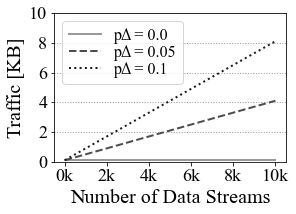



Show every 3rd row of data:


,num_controllers,diff_percentage,diffs,bandwidth_per_controller_KB,bandwidth_KB
0,10,0.00,0,0.104,1.04
3,300,0.00,0,0.104,31.20
6,600,0.00,0,0.104,62.40
9,2000,0.00,0,0.104,208.00
12,5000,0.00,0,0.104,520.00
15,8000,0.00,0,0.104,832.00
18,10,0.05,0,0.104,1.04
21,300,0.05,15,0.224,67.20
24,600,0.05,30,0.344,206.40
27,2000,0.05,100,0.904,1808.00


In [21]:
config = {
    "diff_percentages": [0, 0.05, 0.1],
    "controller_options": [10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
}

df = build_figure7a_df(config=config)

build_figure_7a(data=df)

print("\n\nShow every 3rd row of data:")
display(df[df.index % 3 == 0])

# uncomment to show the full data:
# display(df)

### Privacy Controller - Transformation Phase: Storage (Figure 7b) 
During the privacy transformation phase, a privacy controller needs to store the pre-computed secure aggregation graphs and all the shared keys of the other participants.
We show analytically how the storage requirements grow as we increase the number of involved parties.


In [22]:
def build_figure7b_df(config):
    
    params = []
    # Note: see later a more descriptive version of how to get the optimal parameters
    
    for N in range(100, config["N_limit"]+1, config["N_step_size"]):
        k = _get_k(N=N, alpha=config["alpha"], delta=config["delta"])
        if k:
            w = 2**k
            n = int(config["alpha"] * N)
            W = int(128/k) * w
            p = 1 / w
            d ={
                    "N": N, "n": n, "k": k, "w": w, "W": W, "p": p,
                    "fail_bound": W * er_probability_bound(n=n, p=p),
                    "e_degree": (N-1) / w,
                    "alpha": config["alpha"],
                    "delta": config["delta"]
            }
            params.append(d)
        else:
            d ={
                "N": N,
                "alpha": config["alpha"],
                "delta": config["delta"]
            }
            params.append(d)

    df = pd.DataFrame(params)
    
    # 128 bit ouput of prf, have k-bit segements => have 128/k segments
    df["storage"] = 128 / df["k"]

    df["storage_sharedkeys_kb"] =  df["N"] * 32 / 1000

    # df["storage"] is the number of segments, for each segment we need to store the id of every participant once (*N), each id is a long (*8)
    df["storage_kb"] = df["storage_sharedkeys_kb"] + df["storage"] * df["N"] * 8 / 1000
    
    
    df = df[["N", "k", "storage_kb", "storage_sharedkeys_kb"]]
    
    return df

    
def build_figure_7b(data):

    plt_params = {'backend': 'ps',
              'axes.labelsize': 20,
              'legend.fontsize': 16,
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'font.size': 18,
              'figure.figsize': [4.151100041511, 2.736555644111891],
              'font.family': 'times new roman'}
    
    plt.rc('pdf', fonttype=42) 
    plt.rcParams.update(plt_params)
    
    f, ax1 = plt.subplots()    
    
    capsize = 5
    

    plt.errorbar(data["N"], data["storage_kb"],  yerr=None, label="Shared Keys + Graphs", color="0.1", marker=None, linestyle=':', linewidth=2, capsize=capsize)

    plt.errorbar(data["N"], data["storage_sharedkeys_kb"],  yerr=None, label="Shared Keys", color="0.3", marker=None, linestyle='-', linewidth=2, capsize=capsize)
    
    
    
    plt.gca().grid(True, linestyle=':', axis="y", color='0.6', zorder=0, linewidth=1)
    
    plt.xlabel("Parties")
    plt.ylabel("Storage [KB]")
  
    plt.ylim(ymin=0, ymax=2999)


    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax1.legend(handles, labels ,numpoints=1, title=None ,labelspacing=.08)

    
    loc = plticker.MultipleLocator(base=500)
    ax1.yaxis.set_major_locator(loc)        

    loc = plticker.MultipleLocator(base=2000)
    ax1.xaxis.set_major_locator(loc)
    
    ax1.xaxis.set_major_formatter(lambda x, pos: f"{int(x/1000)}k")
      
    plt.show()
    
    

def er_probability_bound(n, p):
    bound = 0.0
    for j in range(1, int(n/2) + 1):
        uj = ((math.e * n)/j * (1-p) ** (n-j))**j
        bound += uj
    return bound

def _get_k(N, alpha, delta):
    n = int(alpha * N)
         
    for k in range(1, 20):
        w = 2**k
        W = int(128/k) * w
        
        p = 1 / w

        fail_bound = W * er_probability_bound(n=n, p=p)
        
        if fail_bound > delta:
            if k-1 > 0:
                return k-1
            else:
                return None


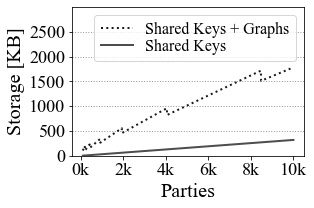



Show every 50'th row of data:


,N,k,storage_kb,storage_sharedkeys_kb
0,100,1,105.600000,3.2
50,600,3,224.000000,19.2
100,1100,4,316.800000,35.2
150,1600,4,460.800000,51.2
200,2100,5,497.280000,67.2
250,2600,5,615.680000,83.2
300,3100,5,734.080000,99.2
350,3600,5,852.480000,115.2
400,4100,6,830.933333,131.2
450,4600,6,932.266667,147.2


In [23]:
config = {
    "alpha": 0.5,
    "delta": 1.0E-7,
    "N_limit": 10000,
    "N_step_size": 10
}

df = build_figure7b_df(config=config)

build_figure_7b(data=df)

print("\n\nShow every 50'th row of data:")
display(df[df.index % 50 == 0])

# uncomment to show the full data:
#display(df)

### Privacy Controller - Transformation Phase: Drop-Outs (Figure 8)

Code Marker: [PrivacyControllerBenchmark.java](zeph-benchmarks/zeph-microbenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/PrivacyControllerBenchmark.java)

#### `Optional:` Run the Microbenchmark for Figure 8 locally (~1h 10min)


In [24]:
%%time
# addE_addNE_dropE_dropNE: addE-> number of returning parties with which we share a mask in the token (edge), addNE-> number of returning parties with which we don't share a mask (edge) in the token

# added: 0_10_0_0,0_50_0_0,0_100_0_0,0_200_0_0,0_300_0_0,0_400_0_0,0_500_0_0
# dropped: 0_0_0_10,0_0_0_50,0_0_0_100,0_0_0_200,0_0_0_300,0_0_0_400,0_0_0_500
# combined: 0_10_0_10,0_50_0_50,0_100_0_100,0_200_0_200,0_300_0_300,0_400_0_400,0_500_0_500

#!java -jar zeph-benchmarks/zeph-microbenchmarks/target/zeph-microbenchmarks-1.0.jar testUniverseDelta -rf json -rff results/review-results/local/figure8_out.json -p dataDir=data -p universeSize=1000 -p addE_addNE_dropE_dropNE=0_10_0_0,0_50_0_0,0_100_0_0,0_200_0_0,0_300_0_0,0_400_0_0,0_500_0_0,0_0_0_10,0_0_0_50,0_0_0_100,0_0_0_200,0_0_0_300,0_0_0_400,0_0_0_500,0_10_0_10,0_50_0_50,0_100_0_100,0_200_0_200,0_300_0_300,0_400_0_400 2>&1 | tee logs/figure8.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/figure8.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/figure8.log))

CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 2.9 ms


#### Description 

Parties can dynamically dropout or return from a previous dropout. Incorporating these changes into the transformation token has a small overhead depending on the number of changes (delta). 
As a first step, we benchmarked the difference between a return/dropout from a participant with and without a shared mask in the token. We observed that the difference was marginal and thus we only focus the benchmark on reacting to changes from participants that do not share a pairwise mask in the token. The reason for this is that, the number of pairwise shared masks is small and hence the number of parties that could return or dropout (x-axis) would be limited. 

In [25]:
def build_figure8_df(file):
    
    try:
        with open(file) as json_file:
            data = json.load(json_file)
    except (FileNotFoundError, ValueError) as e:
        return None

    results = []

    for x in data:
        benchmark_class = x['benchmark'].split(".")[-1]

        if benchmark_class != "testUniverseDelta":
            continue

        benchmark = x['benchmark'].split(".")[-1]

        parts = x['params']['addE_addNE_dropE_dropNE'].split("_")
        score = x['primaryMetric']['score']
        unit = x['primaryMetric']['scoreUnit']

        stddev = stat.stdev(x['primaryMetric']['rawData'][0])

        d = {
            "n_parties": x['params']['universeSize'],
            "addE": parts[0],
            "addNE": parts[1],
            "dropE": parts[2],
            "dropNE": parts[3],
            "latency": score,
            "stddev": stddev,
            "unit": unit,
            "maxDelta": max(map(lambda x: int(x), parts))
        }

        results.append(d)


    df = pd.DataFrame(results)
    df = df.drop_duplicates(['n_parties', 'addE', 'addNE', 'dropE', 'dropNE']).sort_values(['maxDelta'])


    df = df[df['maxDelta'].astype(int)<500]

    df = df[["n_parties", "addNE", "dropNE", "latency", "stddev", "unit", "maxDelta"]]
    df = df.rename(columns={"addNE": "n_parties_added", "dropNE": "n_parties_dropped"})
    

    
    def _get_type(row):
        n_parties_added = int(row["n_parties_added"])
        n_parties_dropped = int(row["n_parties_dropped"])
        
        
        if n_parties_added == 0 and n_parties_dropped  > 0:
            return "dropped"
        elif n_parties_added > 0 and n_parties_dropped==0:
            return "returned"
        elif n_parties_added > 0 and n_parties_dropped>0:
            return "combined"
        else:
            return "none"
    
    
    df["type"] = df.apply(lambda x: _get_type(x), axis=1)
    
    df = df[df["type"] != "none"]
    
    df = df.sort_values(["type","maxDelta"])    


    return df

def build_figure_8(data, format_plot):
    

    colors=["0.1", "0.3", "0.6"]
    linestyles=[":", "--", "-"]

    df_dropped = data[data["type"]=="dropped"]
    df_returned = data[data["type"]=="returned"]
    df_combined = data[data["type"]=="combined"]

    plt_params = {'backend': 'ps',
              'axes.labelsize': 20,
              'legend.fontsize': 16,
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'font.size': 18,
              'figure.figsize': [4.151100041511, 2.736555644111891],
              'font.family': 'times new roman'}
    
    plt.rc('pdf', fonttype=42) 
    plt.rcParams.update(plt_params)

    f, ax1 = plt.subplots()    
    
    capsize = 5
    
    plt.errorbar(df_dropped["maxDelta"], df_dropped["latency"]/1000,  yerr=df_dropped["stddev"]/1000, label="Dropped", color=colors[0], marker=None, linestyle=linestyles[0], linewidth=2, capsize=capsize)
    plt.errorbar(df_returned["maxDelta"], df_returned["latency"]/1000,  yerr=df_returned["stddev"]/1000, label="Returned", color=colors[1], marker=None, linestyle=linestyles[1], linewidth=2, capsize=capsize)
    plt.errorbar(df_combined["maxDelta"], df_combined["latency"]/1000,  yerr=df_combined["stddev"]/1000, label="Combined", color=colors[2], marker=None, linestyle=linestyles[2], linewidth=2, capsize=capsize)
    
    
    plt.gca().grid(True, linestyle=':', axis="y", color='0.6', zorder=0, linewidth=1)
    
    plt.xlabel("Parties [Δ]")
    plt.ylabel("Computation [ms]")
  
    ymax = None
    if format_plot:
        ymax= 0.75
        
        loc = plticker.MultipleLocator(base=0.2)
        ax1.yaxis.set_major_locator(loc)        

        loc = plticker.MultipleLocator(base=100)
        ax1.xaxis.set_major_locator(loc)

    plt.ylim(ymin=0, ymax=ymax)

    handles, labels = ax1.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax1.legend(handles, labels ,numpoints=1, title=None ,labelspacing=.08)
    
          
    plt.show()

#### Paper Results

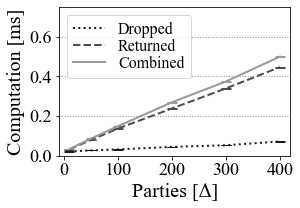

,n_parties,n_parties_added,n_parties_dropped,latency,stddev,unit,maxDelta,type
19,1000,10,10,34.050341,0.580871,us/op,10,combined
20,1000,50,50,86.797568,0.560283,us/op,50,combined
21,1000,100,100,149.250568,1.428473,us/op,100,combined
22,1000,200,200,269.877543,2.062880,us/op,200,combined
27,1000,300,300,374.864016,2.519177,us/op,300,combined
28,1000,400,400,500.109543,2.725325,us/op,400,combined
11,1000,0,10,21.421411,0.316984,us/op,10,dropped
13,1000,0,50,27.498522,0.523997,us/op,50,dropped
16,1000,0,100,32.270630,0.514671,us/op,100,dropped
17,1000,0,200,45.046231,0.608595,us/op,200,dropped


---

#### AWS Results

does not exist yet


---

#### Local Results

does not exist yet


---

In [26]:
file_d = {"paper": "figure8_out.json", "aws": "jmh-microbenchmark-results_0.json", "local": "figure8_out.json"}

def output(source):
    
    df = build_figure8_df(file=get_result_path(source.lower(), file_d))
    
    display(Markdown(f"#### {source} Results"))
    
    if df is None:
        print("does not exist yet")
    else:
        build_figure_8(data=df, format_plot=source!="Local")
        display(df)
    
    display(Markdown("---"))

for source in ["Paper","AWS","Local"]:
    output(source)

### Privacy Controller - Secure Aggregation Optimization

The Zeph Secure Aggregation optimization constructs a series of random graphs. The number of graphs (rounds per epochs) depends on the number of parties (`N`), the assumption on the maximum fraction of colluding parties (`alpha`), and a failure probability bound (`delta`). (Details can be found in the supplementary material of the paper)

We show how many graphs we can construct with a given configuration and the resulting number of prf evaluations and  additions in comparison to Dream and Strawman.

In [27]:
def build_secure_aggregation_comparison_df(config):
    
    optimal_k = _get_opt_k(N=config["N"], alpha=config["alpha"], delta=config["delta"])
    
    if optimal_k is None:
        print(f"The config={config} cannot be satisfied.")
        return None
    
    num_graphs_per_segment = 2**optimal_k
    min_num_honest_clients = int(config["alpha"] * config["N"])
    
    num_graphs = int(128/optimal_k) * num_graphs_per_segment # number of rounds in epoch
    
    d = {
        "N": config["N"],
        "alpha": config["alpha"],
        "delta": config["delta"],
        "b": optimal_k,
        "n_rounds_per_epoch": num_graphs,
        "small_graph_expected_degree": round((config["N"]-1) / num_graphs_per_segment),
        "clique_graph_degree": config["N"] -1
    }
    
    num_fields_per_event = 1
    
    d["zeph_num_prf"] =  num_fields_per_event * d["n_rounds_per_epoch"] * d["small_graph_expected_degree"] +  config["N"] -1
    d["zeph_num_add"] =  num_fields_per_event * d["n_rounds_per_epoch"] * d["small_graph_expected_degree"]
    
    # dream creates in each round a new small graph. Deriving and adding the mask has to be done in each round on the small graph
    d["dream_num_add"] =  num_fields_per_event * d["n_rounds_per_epoch"] * d["small_graph_expected_degree"] 
    d["dream_num_prf"] = d["n_rounds_per_epoch"] * (num_fields_per_event * d["small_graph_expected_degree"] +  config["N"] - 1)
    
    d["strawman_num_prf"] = num_fields_per_event * d["n_rounds_per_epoch"] * d["clique_graph_degree"] 
    d["strawman_num_add"] = num_fields_per_event * d["n_rounds_per_epoch"] * d["clique_graph_degree"] 
    
    df = pd.DataFrame([d])
    
    return df.set_index(["N", "alpha", "delta"])
    
    
def _er_probability_bound(n, p):
    # bound on probability that erdos renyi graph G(n,p) is disconnected
    bound = 0.0
    for j in range(1, int(n/2) + 1):
        uj = ((math.e * n)/j * (1-p) ** (n-j))**j
        bound += uj
    return bound

def _get_opt_k(N, alpha, delta):
    min_num_honest_clients = int(alpha * N)
         
    # try to find largest k such that failure probability threshold delta is satisfied
    for k in range(1, 20):
        
        num_graphs_per_segment = 2**k 
        num_graphs = int(128/k) * num_graphs_per_segment
        
        # each graph (of honest clients) is erdos renyi graph with:
        p = 1 / num_graphs_per_segment

        # union bound over the number of graphs
        fail_bound = num_graphs * er_probability_bound(n=min_num_honest_clients, p=p)
        
        # if fail bound is greater than delta, then the previous k is the max k that satisfies the bound
        if fail_bound > delta:
            if k-1 > 0:
                return k-1
            else:
                return None
        

In [28]:
config = {
    "N": 10000, # number of parties (privacy controllers)
    "alpha": 0.5, # max fraction of parties colluding with adversary
    "delta": 1.0E-9# failure probability threshold
}

df = build_secure_aggregation_comparison_df(config=config)

display(df)

,,,b,n_rounds_per_epoch,small_graph_expected_degree,clique_graph_degree,zeph_num_prf,zeph_num_add,dream_num_add,dream_num_prf,strawman_num_prf,strawman_num_add
N,alpha,delta,,,,,,,,,,
10000,0.5,1.000000e-09,7,2304,78,9999,189711,179712,179712,23217408,23037696,23037696


## End-to-End Application Scenarios (Figure 9)
Since in the end-to-end setting, Zeph relies on and is comprised of multiple components (distributed data producers, distributed privacy controllers, Kafka cluster, Kafka Streams data transformer), we run Zeph in this setting only on AWS.
The transformations in the end-to-end experiments aggregate over all attributes and encodings to show the worst-case performance for the specific application.

**Note that you cannot run the end-to-end benchmark while the microbenchmarks are running on AWS**

#### Running **All** End-to-End Benchmarks on AWS (2h 30min~ min)
The complete end-to-end benchmark for figure 9 can be run with the command below.


In [29]:
HTML(' <a href="", data-commandlinker-command="terminal:create-new" >Open new Terminal</a> (alternative to execute shell command in a blocking cell)')

In [30]:
%%time
# Execute the full benchmark with all three applications and 300 and 1200 parties:

#!ansible-playbook ansible/e2epaper.yml -i ansible/inventory --private-key ~/.ssh/id_rsa_zeph --ssh-common-args='-o StrictHostKeyChecking=no' --forks=24 2>&1 | tee logs/e2e_full.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/e2e_full.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/e2e_full.log))

CPU times: user 0 ns, sys: 3.47 ms, total: 3.47 ms
Wall time: 2.71 ms


#### Running **a single** End-to-End Benchmark on AWS (~ 1h 10min)

In [31]:
%%time
# Execute the benchmark (plaintext vs zeph) for a fix number of clients and for only one application.

# application one of [polar, web, car]
# num_parties must be a multiple of 300 (due to the three client regions and 100er partitioning)
# forks: the provided number of forks only supports up to 1200 clients.

# Advanced: if you want to run two or more experiments with this command, you could comment out the "Cleanup AWS" in ansible/e2esingle.yml and in the end use the command at the top of the JupyterLab to cleanup all resources. 
# (has the advantage that in between two runs, we don't terminate all resources and have to start them again for the next run) 


#!ansible-playbook ansible/e2esingle.yml -i ansible/inventory -e "application=car num_parties=300" --forks 24 --private-key ~/.ssh/id_rsa_zeph --ssh-common-args='-o StrictHostKeyChecking=no' 2>&1 | tee logs/e2e_single.log
clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/e2e_single.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/e2e_single.log))

CPU times: user 3.71 ms, sys: 0 ns, total: 3.71 ms
Wall time: 2.91 ms


In [32]:
def build_figure9_df(dir):

    folder = dir
    experiments = ["e2e_plaintext_polar", "e2e_plaintext_web", "e2e_plaintext_car", "e2e_zeph_polar", "e2e_zeph_web", "e2e_zeph_car"] 

    files = []
    for exp in experiments:
        f = glob.glob(folder + f"/{exp}_*.json")
        f = [(x, exp) for x in f]
        files += f

    zeph = []
    plaintext = []

    grace = 5000 # the earliest possible moment where the data transformer could output the result is when the 5s grace period is over (after window closes)

    for file, exp in files:
        with open(file) as json_file:
            data = json.load(json_file)

        latency = 0
        count = 0

        latencies = []

        for res in data["data"][2:-2]: # exclude a warmup period and a cool down period
            latency += res["latency"] 
            count += 1
            latencies.append(res["latency"]- grace)

        if count < 8:
            print(f"not enough data points: {file}")
            continue


        avg_latency = latency / count - grace

        parties = data["config"]["universeSize"]
        expo_delay_mean = data["config"]["expoDelayMean"]

        d = {
                "parties": int(parties),
                "latency": int(avg_latency),
                "expo_delay_mean": expo_delay_mean,
                "latencies": np.array(latencies),
                "median_latency": stat.median(latencies),
                "exp_id": exp,
                "application": exp.split("_")[-1]
            }
        

        benchmarkType = data['config']['benchmarkType']

        if benchmarkType == 'zeph'or benchmarkType == 'policycrypt':
            zeph.append(d)
        elif benchmarkType == 'plaintext':
            plaintext.append(d)
        else:
            print(f"unknown benchmark type: {file}")

    if len(zeph) == 0:
        return None
    
    df_zeph = pd.DataFrame(zeph).rename(columns={"median_latency": "median_latency_zeph_ms" ,"latency": "mean_latency_zeph_ms", "latencies": "latencies_zeph_ms"})
    df_zeph = df_zeph.sort_values(by=['exp_id']) 
    df_zeph =   df_zeph.drop_duplicates(subset=['parties', 'application'], keep="last") # for duplicates, keep element with highest exp_id (i.e. later result file)
    
    df_plaintext = pd.DataFrame(plaintext).rename(columns={"median_latency": "median_latency_plaintext_ms", "latency": "mean_latency_plaintext_ms", "latencies": "latencies_plaintext_ms"}) #.drop_duplicates()
    df_plaintext = df_plaintext.sort_values(by=['exp_id']) 
    df_plaintext =   df_plaintext.drop_duplicates(subset=['parties', 'application'], keep="last")
    
    df = df_zeph.merge(df_plaintext, how='outer', on=['parties', 'expo_delay_mean', 'application']).sort_values(by=['application', 'parties'])  
    df = df.drop(columns=['exp_id_x', 'exp_id_y'])
    df["median_difference_ms"] = df["median_latency_zeph_ms"] - df["median_latency_plaintext_ms"]
    
    
    df["overhead_factor_median"] = df["median_latency_zeph_ms"] / df["median_latency_plaintext_ms"]
    try:
        df["overhead_factor_median"] = df["overhead_factor_median"].apply(lambda x: f"{int(round(x))}x")
    except ValueError:
        pass
    
    return df

def build_figure_9(data, plot_format):
    
    fig_width_pt = 300.0  # Get this from LaTeX using \showthe
    inches_per_pt = 1.0 / 72.27 * 2  # Convert pt to inches
    golden_mean = ((np.math.sqrt(5) - 1.0) / 2.0) * .8  # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt  # width in inches
    fig_height = (fig_width * golden_mean)  # height in inches
    fig_size =  [fig_width, fig_height]

    colors=["0.1", "0.45", "0.7"]
    linestyles=[":", "--", "-"]
    
    figsize=[fig_size[0], 2/3 * fig_size[1]]

    plt_params = {'backend': 'ps',
                  'axes.labelsize': 20,
                  'legend.fontsize': 16,
                  'xtick.labelsize': 18,
                  'ytick.labelsize': 18,
                  'font.size': 18,
                  'figure.figsize': fig_size,
                  'font.family': 'times new roman'}
    

    plt_params_bp = plt_params
    plt_params_bp['figure.figsize'] = figsize
    
    plt.rcParams.update(plt_params_bp)
    plt.rc('pdf', fonttype=42)

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
        plt.setp(bp['fliers'], color=color)
        #plt.setp(bp['outliers'], color=color)

    scale = 2
    widths = 0.5
    

    fig, axes = plt.subplots(ncols=3, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    
  
    for i, ax, app, name in zip(range(3), axes, ["polar", "web", "car"], ["Fitness App", "Web Analytics", "Car Sensors"]):
        df_exp = data[(data["application"] == app)]
        
        if i == 0:
            ax.set_ylabel("Latency [sec]")

        if i == 1:
            ax.set_xlabel("Data Producers / Privacy Controllers")


        
        if df_exp.empty and i == 2:
            ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Plaintext", "Zeph"])
            continue
        elif df_exp.empty:
            continue

        labels = df_exp["parties"].values
        values1 = df_exp["latencies_plaintext_ms"].values / 1000
        values2 = df_exp["latencies_zeph_ms"].values / 1000
    
        positions1 = np.array(range(len(values1))) * scale - 0.3
        positions2 = np.array(range(len(values2))) * scale + 0.3
    
        bp1 = ax.boxplot(values1, False, '+', positions=positions1, patch_artist=True, widths=widths)
        set_box_color(bp1, colors[0])   
   
        bp2 = ax.boxplot(values2, False, '+', positions=positions2, patch_artist=True, widths=widths)
        set_box_color(bp2, colors[1])

        if i == 2:
            ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Plaintext", "Zeph"])
        
        

        ax.set_xlim(-1, len(labels) * scale - 1)

        ax.set_ylim(ymin=0)
        ax.set_xticks(range(0, len(labels) * scale, scale))
        ax.set(xticklabels=labels)
        
        if plot_format:
            ax.yaxis.set_major_locator(plticker.MultipleLocator(0.5))

        ax.grid(True, axis="y", linestyle=':', color='0.6', zorder=0, linewidth=1.2)

        ax2 = ax.twiny()
        ax2.set_xticks([])
        ax2.set_xlabel(name)
    
    plt.show()

#### Paper Results

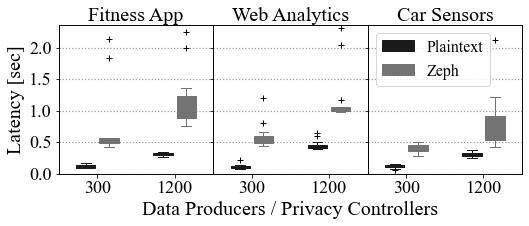

,parties,mean_latency_zeph_ms,expo_delay_mean,latencies_zeph_ms,median_latency_zeph_ms,application,mean_latency_plaintext_ms,latencies_plaintext_ms,median_latency_plaintext_ms,median_difference_ms,overhead_factor_median
1,300,412,0.5,"[511, 436, 505, 414, 399, 287, 378, 460, 349, 427, 302, 365, 504, 440]",420.5,car,114,"[80, 128, 135, 110, 132, 153, 109, 63, 152, 97, 107, 112, 105]",110.0,310.5,4x
0,1200,857,0.5,"[1196, 2126, 1222, 912, 757, 758, 692, 806, 743, 496, 469, 531, 433]",757.0,car,307,"[315, 247, 295, 374, 296, 355, 325, 311, 315, 274, 259, 315, 360, 270]",313.0,444.0,2x
2,300,728,0.5,"[2137, 1835, 452, 492, 575, 506, 471, 521, 427, 562, 481, 522, 487]",506.0,polar,122,"[121, 160, 134, 105, 176, 137, 168, 96, 98, 102, 98, 85, 108]",108.0,398.0,5x
3,1200,1145,0.5,"[2253, 2001, 889, 955, 761, 973, 1056, 895, 880, 1232, 805, 1361, 829]",955.0,polar,314,"[345, 344, 318, 268, 338, 305, 305, 341, 305, 317, 319, 298, 285]",317.0,638.0,3x
5,300,605,0.5,"[806, 661, 492, 511, 583, 452, 466, 1197, 437, 591, 600, 574, 531, 574]",574.0,web,115,"[84, 113, 122, 105, 115, 115, 87, 142, 93, 221, 75, 95, 132]",113.0,461.0,5x
4,1200,1193,0.5,"[2310, 1179, 1005, 1031, 1001, 983, 1008, 1055, 2051, 1027, 996, 989, 1001, 1068]",1017.5,web,461,"[509, 410, 441, 420, 427, 394, 438, 459, 647, 441, 602, 413, 395]",438.0,579.5,2x


---

#### AWS Results

does not exist yet


---

In [33]:
def output(source):
    df = build_figure9_df(dir=get_result_path(source.lower()))
    display(Markdown(f"#### {source} Results"))
    
    if df is None or df.empty:
        print("does not exist yet")
    else:
        build_figure_9(data=df, plot_format=source=="Paper")
        
        display(df)
    
    display(Markdown("---"))

for source in ["Paper","AWS"]:
    output(source)

### Troubleshooting End-to-End

If the AWS Results plot does not show all expected results:

1. check the end of the [Cell Output](logs/e2e_full.log) to verify that the play recap shows `unreachable=0` and `failed=0` for all hosts. (if `unreachable=0` it is possible that the ssh connection between JupyterLab and a host machine was interrupted)
2. check the results folder `results/review-results/aws` to verify that there is a file for each application `polar, web, car` both for `plaintext, zeph` and for `300, 1200`participants. If a file is empty, re-run the specific configuration with the command above.   

### Further Details about End-to-End Experiments 

#### Data Producer and Privacy Controller (Client)
The data producers and the privacy controllers are grouped into partitions (either 100 producers or 100 privacy controllers).
Each partition uses the [E2EBenchmarkRunner.java](zeph-benchmarks/zeph-macrobenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/macro/e2e/E2EBenchmarkRunner.java) to run the benchmark and performs these basic steps:
1. wait until all partitions are ready 
2. execute the benchmark by either producing a data stream or producing a token stream 
3. report performance

The [e2eclient role](ansible/roles/e2eclient/tasks/main.yml) in the ansible playbook is responsible for starting the partitions involved in a benchmark on the ec2 machines.

#### Data Transformer (Server)
The data transformer (stream processor) that executes the privacy transformation consists of a master ([MasterApp.java](zeph-server/zeph-server-master/src/main/java/ch/ethz/infk/pps/zeph/server/master/MasterApp.java)) that is shared between transformations and a worker ([WorkerApp.java](zeph-server/zeph-server-worker/src/main/java/ch/ethz/infk/pps/zeph/server/worker/WorkerApp.java)) that is specific for a privacy transformation. Both the master and the worker application can be started multiple times and Kafka Streams ensures to distribute the workload among the available instances. In the end-to-end benchmark, we benchmark a single transformation running on two worker instances and one master instance.

The [zephmaster role](ansible/roles/zephmaster/tasks/main.yml) and the [zephworker role](ansible/roles/zephworker/tasks/main.yml) start the components as a systemd service.

#### Plaintext Baseline

In the plaintext baseline there are only data producers (i.e., no privacy controllers) and a single type of data transformer ([PlaintextApp.java](zeph-server/zeph-server-worker/src/main/java/ch/ethz/infk/pps/zeph/server/worker/PlaintextApp.java)). Note, the available computational resources are the same as in Zeph (same number of server machines, data producers run on the same instances). The plaintext data producer are also operated by [E2EBenchmarkRunner.java](zeph-benchmarks/zeph-macrobenchmarks/src/main/java/ch/ethz/infk/pps/zeph/benchmark/macro/e2e/E2EBenchmarkRunner.java).

The [plaintextworker role](ansible/roles/plaintextworker/tasks/main.yml) starts the plaintext worker as a systemd service and the [e2eclient role](ansible/roles/e2eclient/tasks/main.yml) handles the data producers.

#### Switching between Applications
Running benchmark with different applications requires to re-compile Zeph and setting the build profile as shown below.

The Zeph applications are defined in `zeph-shared/applications`. Each application requires a `schema.avsc` file that describes an Input and a Digest.
The input lists how a single event of the application looks in the plaintext case (i.e., the regular stream schema). The digest describes the encoding of this input in Zeph. In the current prototype of Zeph the encoding (containing only lists of longs) has to be defined manually. In addition, the prototype requires an `ApplicationAdapter.java` that defines how to encode an Input into a Digest among minor other things.

Adding support for a new application requires defining such a schema and ApplicationAdapter and in addition register the application in form of a new Maven profile in `zeph-shared/pom.xml`. The Maven build of Zeph ensures that the files of the selected application are moved to the proper location.

In [34]:
%%time
# Switch to the Standard Application that uses an encoding of [x, x², 1] (~ 6 min)
#!mvn clean install 2>&1 | tee logs/build_zeph_standard.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_standard.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_standard.log))

CPU times: user 9.67 ms, sys: 227 µs, total: 9.89 ms
Wall time: 3.57 ms


In [35]:
%%time
# Switch to the Polar Application (~ 6 min)
#!mvn clean install -P polar-application 2>&1 | tee logs/build_zeph_standard.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_polar.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_polar.log))

CPU times: user 6.25 ms, sys: 18.6 ms, total: 24.9 ms
Wall time: 9.81 ms


In [36]:
%%time
# Switch to the Web Application (~ 6 min)
#!mvn clean install -P web-application 2>&1 | tee logs/build_zeph_standard.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_web.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_web.log))

CPU times: user 4.93 ms, sys: 131 µs, total: 5.06 ms
Wall time: 4.05 ms


In [37]:
%%time
# Switch to the Car Application (~ 6 min)
#!mvn clean install -P car-application 2>&1 | tee logs/build_zeph_standard.log

clear_output()
display(Markdown("Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_car.log))"))

Done! Cleared output for conciseness ([Show Cell Output](logs/build_zeph_car.log))

CPU times: user 141 µs, sys: 3.45 ms, total: 3.6 ms
Wall time: 2.89 ms
